# GRAIN ORIENTATION
This Jupyter notebook illustrates the process and functions employed in grain orientation.

## Imports
First of all, make sure all these libraries are installed and can be imported.

In [1]:
import numpy as np
import pyrender
import trimesh
import os

import math
import copy
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

from tqdm.notebook import tnrange, tqdm
from ipywidgets import widgets, Layout
from IPython.display import display, clear_output

### Functions
The functions we're going to define will be used for:
- create and render axis (pyrender)
- compute rotation matrices
- slice meshes
- switch between polar and cartesian coordinates
- align grains over axes

In [2]:
# --------- Axis ---------
def create_axis_x_mesh(length=5.0, radius=0.02, n_sections=8):
    vertices = []
    faces = []

    # Cylinder top
    for i in range(n_sections):
        angle = 2 * np.pi * i / n_sections
        x = length
        y = radius * np.sin(angle)
        z = radius * np.cos(angle)
        vertices.append([x, y, z])

    # Cylinder bottom
    for i in range(n_sections):
        angle = 2 * np.pi * i / n_sections
        x = 0
        y = radius * np.sin(angle)
        z = radius * np.cos(angle)
        vertices.append([x, y, z])

    # Cylinder faces
    for i in range(n_sections):
        next_i = (i + 1) % n_sections
        faces.append([i, next_i, i + n_sections])
        faces.append([i + n_sections, next_i, next_i + n_sections])

    return trimesh.Trimesh(vertices=vertices, faces=np.array(faces, dtype=np.int32))

def create_axis_y_mesh(length=5.0, radius=0.02, n_sections=8):
    vertices = []
    faces = []

    # Cylinder top
    for i in range(n_sections):
        angle = 2 * np.pi * i / n_sections
        x = radius * np.cos(angle)
        y = length
        z = radius * np.sin(angle)
        vertices.append([x, y, z])

    # Cylinder bottom
    for i in range(n_sections):
        angle = 2 * np.pi * i / n_sections
        x = radius * np.cos(angle)
        y = 0
        z = radius * np.sin(angle)
        vertices.append([x, y, z])

    # Cylinder faces
    for i in range(n_sections):
        next_i = (i + 1) % n_sections
        faces.append([i, next_i, i + n_sections])
        faces.append([i + n_sections, next_i, next_i + n_sections])

    return trimesh.Trimesh(vertices=vertices, faces=np.array(faces, dtype=np.int32))

def create_axis_z_mesh(length=5.0, radius=0.02, n_sections=8):
    vertices = []
    faces = []

    # Cylinder top
    for i in range(n_sections):
        angle = 2 * np.pi * i / n_sections
        x = radius * np.cos(angle)
        y = radius * np.sin(angle)
        z = length
        vertices.append([x, y, z])

    # Cylinder bottom
    for i in range(n_sections):
        angle = 2 * np.pi * i / n_sections
        x = radius * np.cos(angle)
        y = radius * np.sin(angle)
        z = 0
        vertices.append([x, y, z])

    # Cylinder faces
    for i in range(n_sections):
        next_i = (i + 1) % n_sections
        faces.append([i, next_i, i + n_sections])
        faces.append([i + n_sections, next_i, next_i + n_sections])

    return trimesh.Trimesh(vertices=vertices, faces=np.array(faces, dtype=np.int32))

def create_axis(length=5.0, radius=0.02):
    meshx = create_axis_x_mesh(length, radius)
    meshy = create_axis_y_mesh(length, radius)
    meshz = create_axis_z_mesh(length, radius)
    return meshx, meshy, meshz

def render_axis(meshx, meshy, meshz):
    # X axis RED
    render_meshx = pyrender.Mesh.from_trimesh(
        meshx, material=pyrender.MetallicRoughnessMaterial(
        baseColorFactor=[1.0, 0.0, 0.0, 1.0]))
    # Y axis GREEN
    render_meshy = pyrender.Mesh.from_trimesh(
        meshy, material=pyrender.MetallicRoughnessMaterial(
	    baseColorFactor=[0.0, 1.0, 0.0, 1.0]))
    # Z axis BLUE
    render_meshz = pyrender.Mesh.from_trimesh(
        meshz, material=pyrender.MetallicRoughnessMaterial(
	    baseColorFactor=[0.0, 0.0, 1.0, 1.0]))
    return render_meshx, render_meshy, render_meshz

# --------- Rotation matrices ---------
def rodrigues_rotation_matrix(omega, theta):
    """
    Computes the rotation matrix of angle theta
    with respect to the omega axis.
    
    Parameters:
        omega (np.array | List): Rotation axis vector.
        theta (float): Angle of rotation in radians.
    
    Returns:
        np.array[3,3]: Rotation matrix.    
    """
    if (isinstance(omega, np.ndarray) and len(omega.shape) == 1
            and omega.shape[0] == 3):
        o_norm = omega/np.linalg.norm(omega)

    elif isinstance(omega, list) and len(omega) == 3:
        o_norm = np.array(omega)
        o_norm = omega/np.linalg.norm(omega)

    o_matrix = np.array([
        [0, -o_norm[2], o_norm[1]],
        [o_norm[2], 0, -o_norm[0]],
        [-o_norm[1], o_norm[0], 0]
    ])
    rotation_matrix = (np.identity(3) + o_matrix * np.sin(theta) +
                       np.matmul(o_matrix, o_matrix) * (1 - np.cos(theta)))
    return rotation_matrix

def x_rotation_matrix(theta):
    """
    Computes the rotation matrix of angle theta
    with respect to the x axis.
    
    Parameters:
        theta (float): Angle of rotation in radians.
    
    Returns:
        np.array[3,3]: Rotation matrix.    
    """
    rotation_matrix_x = np.array([
        [1, 0, 0],
        [0, math.cos(theta), -math.sin(theta)],
        [0, math.sin(theta), math.cos(theta)]
        ])
    return rotation_matrix_x

def y_rotation_matrix(theta):
    """
    Computes the rotation matrix of angle theta
    with respect to the y axis.
    
    Parameters:
        theta (float): Angle of rotation in radians.
    
    Returns:
        np.array[3,3]: Rotation matrix.    
    """
    rotation_matrix_y = np.array([
        [math.cos(theta), 0, math.sin(theta)],
        [0, 1, 0],
        [-math.sin(theta), 0, math.cos(theta)]
        ])
    return rotation_matrix_y

def z_rotation_matrix(theta):
    """
    Computes the rotation matrix of angle theta
    with respect to the z axis.
    
    Parameters:
        theta (float): Angle of rotation in radians.
    
    Returns:
        np.array[3,3]: Rotation matrix.    
    """
    rotation_matrix_z = np.array([
        [math.cos(theta), -math.sin(theta), 0],
        [math.sin(theta), math.cos(theta), 0],
        [0, 0, 1]
        ])
    return rotation_matrix_z

# --------- Section functions ---------
def section(mesh, origin_plane, normal_plane):
    return np.array(mesh.section(plane_origin=origin_plane, plane_normal=normal_plane).vertices)

def xsection(mesh, origin_plane=np.array([0,0,0])):
    return section(mesh, origin_plane, np.array([1,0,0]))

def ysection(mesh, origin_plane=np.array([0,0,0])):
    return section(mesh, origin_plane, np.array([0,1,0]))

def zsection(mesh, origin_plane=np.array([0,0,0])):
    return section(mesh, origin_plane, np.array([0,0,1]))

# --------- Polar coordinates ---------
def polar_coordinates(x, y):
    """
    Given x and y numpy arrays, returns the polar coordinates.

    Parameter:
        x (np.array): x coordinates.
        y (np.array): y coordinates.

    Returns:
        np.array: Polar coordinates r and theta.
    """
    r = np.sqrt(x**2+y**2)
    theta = np.arctan2(y, x)
    return r, theta

def cartesian_coordinates_2d(r, theta):
    """
    Given r and theta numpy arrays, returns the cartesian coordinates.

    Args:
        r (np.array): Radial coordinate.
        theta (np.aaray): Angle.

    Returns:
        np.array: Cartesian coordinates x and y.
    """
    x = r * np.cos(theta)
    y = r * np.sin(theta)
    return x, y

# --------- Align functions ---------
def align_x(mesh):
    """
    Aligns the grain such that the eigenvector of
    dominant eigenvalue lies along the x-axis.
    
    Parameters:
        mesh (Trimesh.mesh): Centered mesh of the grain.

    Returns:
        Trimesh.mesh: X-Oriented mesh.
    """
    
    # Principal Component Analysis
    pca = PCA(n_components=3)
    pca.fit(mesh.vertices)
    cov = pca.get_covariance()
    eigenvalues, eigenvectors = np.linalg.eig(cov)

    #print("Eigenvalues: \n", eigenvalues)
    #print("Eigenvectors: \n", eigenvectors)
    #print("Determinant eigenvectors: \n", np.linalg.det(eigenvectors))
    
    # SORTING EIGENVECTORS
    biggest_axis = 0
    ind = np.argmax(eigenvalues)
    if ind != biggest_axis:
        eigenvectors[:, [biggest_axis, ind]] = eigenvectors[:, [ind, biggest_axis]]
        eigenvalues[[biggest_axis, ind]] = eigenvalues[[ind, biggest_axis]]
        mesh.vertices[:, [biggest_axis, ind]] = mesh.vertices[:, [biggest_axis, ind]]

    smallest_axis = 2
    ind = np.argmin(eigenvalues)
    if ind != smallest_axis:
        eigenvectors[:, [smallest_axis, ind]] = eigenvectors[:, [ind, smallest_axis]]
        eigenvalues[[smallest_axis, ind]] = eigenvalues[[ind, smallest_axis]]
        mesh.vertices[:, [biggest_axis, ind]] = mesh.vertices[:, [biggest_axis, ind]]

    if np.linalg.det(eigenvectors) < 0:
        eigenvectors[:, 0] = -eigenvectors[:, 0]
    #print("Eigenvalues: \n", eigenvalues)
    #print("Eigenvectors: \n", eigenvectors)
    #print("Determinant eigenvectors: \n", np.linalg.det(eigenvectors))

    mesh.vertices = np.matmul(eigenvectors.transpose(), mesh.vertices.transpose()).transpose()
    return mesh

def align_y(mesh):
    """
    Aligns the grain along the y-axis by slicing 5 times
    over the x-axis and computing the nearest point of
    every slice to the origin.
    
    Parameters:
        mesh (Trimesh.mesh): X-oriented mesh.

    Returns:
        Trimesh.mesh: XY-Oriented mesh.
    """
    mesh_copy = copy.deepcopy(mesh)
    mesh_copy.vertices /= np.max(np.abs(mesh_copy.vertices[:,0]))/3.5
    xsections = [
        xsection(mesh_copy, origin_plane=np.array([2,0,0])),
        xsection(mesh_copy, origin_plane=np.array([1,0,0])),
        xsection(mesh_copy, origin_plane=np.array([0,0,0])),
        xsection(mesh_copy, origin_plane=np.array([-1,0,0])),
        xsection(mesh_copy, origin_plane=np.array([-2,0,0]))
    ]
    correct_orientation = []
    for xsec in xsections:
        radius, theta = polar_coordinates(xsec[:,2], xsec[:,1])
        ind = np.argmin(radius)
        r_0 = radius[ind]
        t_0 = theta[ind]
        z_0, y_0 = cartesian_coordinates_2d(r_0, t_0)
        #print(z_0, y_0)
        if z_0 > 0:
            correct_orientation.append(1)
        else:
            correct_orientation.append(-1)
    correct_orientation = np.array(correct_orientation)
    if np.sum(correct_orientation) < 0:
        mesh.vertices = np.matmul(x_rotation_matrix(np.pi), mesh.vertices.transpose()).transpose()
    return mesh

def align_z(mesh):
    """
    Aligns the grain along the z-axis computing the
    average x coordinate of a z slice.
    
    Parameters:
        mesh (Trimesh.mesh): XY-oriented mesh.

    Returns:
        Trimesh.mesh: XYZ-Oriented mesh.
    """
    zmin = np.min(mesh.vertices[:, 2])
    zmax = np.max(mesh.vertices[:, 2])
    delta = (zmax-zmin)*0.05

    zsec = zsection(mesh, origin_plane=np.array([0, 0, zmin+delta]))
    if np.mean(zsec[:, 0]) < 0:
        mesh.vertices = mesh.vertices = np.matmul(z_rotation_matrix(np.pi), mesh.vertices.transpose()).transpose()
    return mesh

def align(mesh):
    """
    Centers the grain mesh at the origin, aligns it along 
    the x and y axis and tries to align along the z axis.
    This last z-alignment not always aligns in the desired
    position (93,4% success), so later it has to be checked
    manually.
    
    Parameters:
        mesh (Trimesh.mesh): Mesh of the grain.

    Returns:
        Trimesh.mesh: XYZ-Oriented and centered mesh.
    """
    # Centering mesh
    mesh.vertices = mesh.vertices - mesh.center_mass
    
    # X and Y alignments
    mesh = align_x(mesh)
    mesh = align_y(mesh)
    mesh = align_z(mesh)

    return mesh

def align_dataset(folder_path, destination_path=None, widget=None):
    """
    Travels recursively through the dataset folder and
    makes a copy orienting all the .stl grains.
    
    Parameters:
        folder_path (str): folder path containing the dataset.
        destination_path (None | str): folder path to export oriented dataset.
        widget (None | widget.Text): widget to see the current path.
    """
    # Default name for the new dataset
    if not destination_path:
        destination_path = f"{folder_path}_ORIENTED"
        
    # List of elements in folder
    elements = os.listdir(folder_path)
    elements.sort()
    
    for element in elements:
        path_to_element = f"{folder_path}/{element}"
        path_to_export = f"{destination_path}/{element}"
        extension = os.path.splitext(path_to_element)[1]
        
        # Display current element path
        if widget:
            widget.value = path_to_element
            
        # Recursion over directories
        if os.path.isdir(path_to_element):
            align_dataset(path_to_element, destination_path=path_to_export, widget=widget)

        # Load, align and export mesh
        elif extension == ".stl":
            os.makedirs(destination_path, exist_ok=True)
            mesh = trimesh.load(path_to_element)
            mesh = align(mesh)
            mesh.export(path_to_export)

# --------- Pyrender ---------
def render_folder(folder_path, scene, n_rows, x_separation=10, y_separation=4):
    """
    Renders all .stl files of the given folder and adds them to the scene.
    
    Parameters:
        folder_path (str): folder path containing the grains.
        scene (pyrender.scene.Scene): scene where meshes are displayed.
        n_rows (int): number of rows of the display.
        x_separation (int): distance added to separate in x axis.
        y_separation (int): distance added to separate in y axis.
    """
    paths = os.listdir(folder_path)
    paths.sort()
    for i, path in enumerate(paths):
        import_path = folder_path + "/" + path
        if path[-3:] == "stl":
            mesh = trimesh.load(import_path)
            mesh.vertices = mesh.vertices + np.array([x_separation * (i // n_rows), y_separation * (i % n_rows), 0])
            render_mesh = pyrender.Mesh.from_trimesh(mesh)
            scene.add(render_mesh)

def scene_from_folder(folder_path, n_rows, x_separation=10, y_separation=4):
    """
    Creates a scene with axis, camera, light and all the grains
    of the given folder.
    
    Parameters:
        folder_path (str): folder path containing the grains.
        n_rows (int): number of rows of the display.
        x_separation (int): distance added to separate in x axis.
        y_separation (int): distance added to separate in y axis.
    
    Returns:
        scene (pyrender.scene.Scene): scene where meshes are displayed.
    """
    scene = pyrender.Scene()
    meshx, meshy, meshz = create_axis(length=5.0, radius=0.05)
    render_meshx, render_meshy, render_meshz = render_axis(meshx, meshy, meshz)
    scene.add(render_meshx)
    scene.add(render_meshy)
    scene.add(render_meshz)

    render_folder(folder_path, scene, n_rows)
    # CAMERA AND LIGHT
    camera = pyrender.PerspectiveCamera(yfov=np.pi / 3.0)
    light = pyrender.PointLight(intensity=10.0)

    scene.add(camera, pose=np.eye(4))
    scene.add(light, pose=np.eye(4))
    return scene

def lookAt(eye, target, up, yz_flip=False):
    # https://github.com/Jianghanxiao/Helper3D/tree/master/trimesh_render
    # Normalize the up vector
    up /= np.linalg.norm(up)
    forward = eye - target
    forward /= np.linalg.norm(forward)
    if np.dot(forward, up) == 1 or np.dot(forward, up) == -1:
        up = np.array([0.0, 1.0, 0.0])
    right = np.cross(up, forward)
    right /= np.linalg.norm(right)
    new_up = np.cross(forward, right)
    new_up /= np.linalg.norm(new_up)

    # Construct a rotation matrix from the right, new_up, and forward vectors
    rotation = np.eye(4)
    rotation[:3, :3] = np.row_stack((right, new_up, forward))

    # Apply a translation to the camera position
    translation = np.eye(4)
    translation[:3, 3] = [
        np.dot(right, eye),
        np.dot(new_up, eye),
        -np.dot(forward, eye),
    ]

    if yz_flip:
        # This is for different camera setting, like Open3D
        rotation[1, :] *= -1
        rotation[2, :] *= -1
        translation[1, 3] *= -1
        translation[2, 3] *= -1

    camera_pose = np.linalg.inv(np.matmul(translation, rotation))

    return camera_pose

def custom_scene(render_mesh, camera_eye, camera_target, camera_up, axis_flag=False):
    scene = pyrender.Scene()

    if axis_flag:
        meshx, meshy, meshz = create_axis(length=4.0, radius=0.05)
        render_meshx, render_meshy, render_meshz = render_axis(meshx, meshy, meshz)
        scene.add(render_meshx)
        scene.add(render_meshy)
        scene.add(render_meshz)

    scene.add(render_mesh)
    camera_pose = lookAt(camera_eye, camera_target, camera_up, yz_flip=False)
    camera = pyrender.PerspectiveCamera(yfov=np.pi / 3.0)
    scene.add(camera, pose=camera_pose)

    light = pyrender.PointLight(intensity=50.0)
    scene.add(light, pose=camera_pose)
    return scene

def flip_and_roll(x, y):
    _, theta = polar_coordinates(x, y)
    xx = x
    yy = y
    sorting_indices = np.argsort(theta)
    sorted_theta = theta[sorting_indices]
    xx = x[sorting_indices]
    yy = y[sorting_indices]
    arg_min = np.argmin(np.abs(sorted_theta))
    xx = np.roll(xx, -arg_min)
    yy = np.roll(yy, -arg_min)
    return xx, yy

def grain_sheet(mesh_path):
    # RENDERER
    viewport_width = 640
    viewport_height = 480
    renderer = pyrender.OffscreenRenderer(viewport_width=viewport_width, viewport_height=viewport_height, point_size=1.0)
    
    # LOADING MESH
    mesh = trimesh.load(mesh_path)
    render_mesh = pyrender.Mesh.from_trimesh(mesh)
    
    # AXIS
    axis_flag = True

    # XYZ SCENE
    camera_eye = np.array([4,4,4], dtype=np.float64)
    camera_target = np.array([0,0,0], dtype=np.float64)
    camera_up = np.array([0,1,0], dtype=np.float64)

    scene_xyz = custom_scene(render_mesh, camera_eye, camera_target, camera_up, axis_flag=axis_flag)
    color_xyz, _ = renderer.render(scene_xyz)

    # POSITIVE Z SCENE
    camera_eye = np.array([0,0,6], dtype=np.float64)
    camera_target = np.array([0,0,0], dtype=np.float64)
    camera_up = np.array([0,1,0], dtype=np.float64)

    scene_z_pos = custom_scene(render_mesh, camera_eye, camera_target, camera_up, axis_flag=axis_flag)
    color_z_pos, _ = renderer.render(scene_z_pos)

    # NEGATIVE Z SCENE
    camera_eye = np.array([0,0,-6], dtype=np.float64)
    camera_target = np.array([0,0,0], dtype=np.float64)
    camera_up = np.array([0,1,0], dtype=np.float64)

    scene_z_neg = custom_scene(render_mesh, camera_eye, camera_target, camera_up, axis_flag=axis_flag)
    color_z_neg, _ = renderer.render(scene_z_neg)

    # POSITIVE X SCENE
    camera_eye = np.array([6,0,0], dtype=np.float64)
    camera_target = np.array([0,0,0], dtype=np.float64)
    camera_up = np.array([0,1,0], dtype=np.float64)

    scene_x_pos = custom_scene(render_mesh, camera_eye, camera_target, camera_up, axis_flag=axis_flag)
    color_x_pos, _ = renderer.render(scene_x_pos)

    # NEGATIVE X SCENE
    camera_eye = np.array([-6,0,0], dtype=np.float64)
    camera_target = np.array([0,0,0], dtype=np.float64)
    camera_up = np.array([0,1,0], dtype=np.float64)

    scene_x_neg = custom_scene(render_mesh, camera_eye, camera_target, camera_up, axis_flag=axis_flag)
    color_x_neg, _ = renderer.render(scene_x_neg)

    # POSITIVE Y SCENE
    camera_eye = np.array([0,6,0], dtype=np.float64)
    camera_target = np.array([0,0,0], dtype=np.float64)
    camera_up = np.array([0,0,1], dtype=np.float64)

    scene_y_pos = custom_scene(render_mesh, camera_eye, camera_target, camera_up, axis_flag=axis_flag)
    color_y_pos, _ = renderer.render(scene_y_pos)

    # NEGATIVE Y SCENE
    camera_eye = np.array([0,-6,0], dtype=np.float64)
    camera_target = np.array([0,0,0], dtype=np.float64)
    camera_up = np.array([0,0,1], dtype=np.float64)

    scene_y_neg = custom_scene(render_mesh, camera_eye, camera_target, camera_up, axis_flag=axis_flag)
    color_y_neg, _ = renderer.render(scene_y_neg)

    # VOID SCENE
    camera_eye = np.array([50,0,0], dtype=np.float64)
    camera_target = np.array([60,0,0], dtype=np.float64)
    camera_up = np.array([0,1,0], dtype=np.float64)

    scene_void = custom_scene(render_mesh, camera_eye, camera_target, camera_up, axis_flag=axis_flag)
    color_void, _ = renderer.render(scene_void)

    # X SECTION
    xsec = xsection(mesh)
    yy = xsec[:, 1]
    zz = xsec[:, 2]
    xsec_y, xsec_z = flip_and_roll(yy,zz)

    # Y SECTION
    ysec = ysection(mesh)
    xx = ysec[:, 0]
    zz = ysec[:, 2]
    ysec_x, ysec_z = flip_and_roll(xx,zz)

    # Z SECTION
    zsec = zsection(mesh)
    xx = zsec[:, 0]
    yy = zsec[:, 1]
    zsec_x, zsec_y = flip_and_roll(xx,yy)

    # PLOT
    grain_name = os.path.splitext(os.path.basename(mesh_path))[0]

    fig, axs = plt.subplots(6, 2, constrained_layout=True, figsize=(15,28))
    axs[0, 0].imshow(color_void)
    axs[0, 0].text(0.5*viewport_width, 0.5*viewport_height, grain_name, size=40, rotation=0.,
            ha="center", va="center",
            bbox=dict(boxstyle="round",
                    ec=(1., 0.5, 0.5),
                    fc=(1., 0.8, 0.8),
                    )
            )
    axs[0, 0].axis('off')
    axs[0, 1].imshow(color_void)
    axs[0, 1].axis('off')

    axs[1, 0].imshow(color_xyz)
    axs[1, 0].set_title('+XYZ VIEW')
    axs[1, 0].axis('off')

    axs[1, 1].imshow(color_z_pos)
    axs[1, 1].set_title('+Z VIEW')
    axs[1, 1].axis('off')
    
    axs[2, 0].imshow(color_z_neg)
    axs[2, 0].set_title('-Z VIEW')
    axs[2, 0].axis('off')

    axs[2, 1].imshow(color_x_pos)
    axs[2, 1].set_title('+X VIEW')
    axs[2, 1].axis('off')
    
    axs[3, 0].imshow(color_x_neg)
    axs[3, 0].set_title('-X VIEW')
    axs[3, 0].axis('off')

    axs[3, 1].imshow(color_y_pos)
    axs[3, 1].set_title('+Y VIEW')
    axs[3, 1].axis('off')
    
    axs[4, 0].imshow(color_y_neg)
    axs[4, 0].set_title('-Y VIEW')
    axs[4, 0].axis('off')

    axs[4, 1].plot(xsec_z, xsec_y)
    axs[4, 1].set_title('X=0 SECTION')
    axs[4, 1].set_xlabel('Z COORDINATE')
    axs[4, 1].set_ylabel('Y COORDINATE')

    axs[5, 0].plot(ysec_x, ysec_z)
    axs[5, 0].set_title('Y=0 SECTION')
    axs[5, 0].set_xlabel('X COORDINATE')
    axs[5, 0].set_ylabel('Z COORDINATE')

    axs[5, 1].plot(zsec_x, zsec_y)
    axs[5, 1].set_title('Z=0 SECTION')
    axs[5, 1].set_xlabel('X COORDINATE')
    axs[5, 1].set_ylabel('Y COORDINATE')

    for i in range(4, 6):
        for j in range(2):
            axs[i, j].set_aspect(1, adjustable='box')

    plt.show()
    del renderer

### Step-by-step
Let's import a mesh from our dataset and plot it.

In [3]:
# Load mesh
mesh_path = "./data/unoriented_dataset/Dundee/2ROW British/DHBT16P103 3.stl"
mesh_1 = trimesh.load(mesh_path)

# Create axes in the cartesian origin
meshx, meshy, meshz = create_axis(length=5.0, radius=0.05)

# Create and show a scene conatining the mesh and the axes
scene_1 = trimesh.Scene([mesh_1, meshx, meshy, meshz])
scene_1.show()

As you can see this grain is neither centered nor oriented.

In [4]:
# Align mesh
mesh_2 = align(mesh_1)

# Create and show a scene conatining the mesh and the axes
scene_2 = trimesh.Scene([mesh_2, meshx, meshy, meshz])
scene_2.show()

Now that we know how to align a grain, it's time to align a whole dataset. To do this we're going to use the align_dataset function defined before. This function will walk through the entire dataset, copy its folder structure and save there the oriented grains, so the original data will remain unchanged. Files that are neither folders nor .stl meshes will be ignored.

In [5]:
# Aligning a whole dataset
folder_path = "./data/unoriented_dataset"

# Widget to check progress
widget = widgets.Text(value=folder_path, description="Current path:", layout=Layout(width='75%'))
def update_path(change):
    # Limpiamos la salida actual
    clear_output(wait=True)
    # Mostramos el nuevo valor del texto
    display(widget)
widget.observe(update_path, names='value')

align_dataset(folder_path, widget=widget)  # 3-5 mins for 700 grains

Text(value='./data/unoriented_dataset/Orkney/6ROW Scandinavian/OHBT16P37 9.stl', description='Current path:', …

As described in the align function docstring, z-alignment not always aligns in the desired position (93,4% success), so later it has to be checked manually which grains are not well oriented.

Instead of plotting one grain after another and checking if it's in the right orientation, we'll plot grains by folders and display them in columns. This way we can write down the rows and columns of the problematic grains and fix them.

To demonstrate this we're going to use the folder Barley STL files/Orkney/6ROW Bere/6ROW BERE ORKNEY. The pyrender window will display the grains in this folder and as you will see, grains in column 2 and rows 8 and 9 are not well z-rotated. Remark that the first column and the first row starts at 0, so the second column mentioned before would be the third if we start counting at 1.

In [6]:
folder_path = './data/unoriented_dataset_ORIENTED/Orkney/6ROW Bere/6ROW BERE ORKNEY'
n_rows = 10

# Scene
scene = scene_from_folder(folder_path, n_rows)
viewer = pyrender.Viewer(scene, use_raymond_lighting=True, all_wireframe=False)


Now we write down in the rotate_pairs list the columns and rows of the grains to be fixed following this format: (column, row).

In [7]:
rotate_pairs = [(2, 8), (2, 9)]
rotate_list = [col * n_rows + row for (col, row) in rotate_pairs]

In [8]:
paths = os.listdir(folder_path)
paths.sort()
for i in rotate_list:
    mesh = trimesh.load(folder_path + "/" + paths[i])
    mesh.vertices = mesh.vertices = np.matmul(z_rotation_matrix(np.pi), mesh.vertices.transpose()).transpose()
    mesh.export(folder_path + "/" + paths[i])

In [9]:
# Scene
scene = scene_from_folder(folder_path, n_rows)
viewer = pyrender.Viewer(scene, use_raymond_lighting=True, all_wireframe=False)

As you can see, all grains are well oriented.

## Offscreen rendering
Also we've coded a tool to generate a grain sheet plotting the grain from different perspectives. It only needs the path to the grain

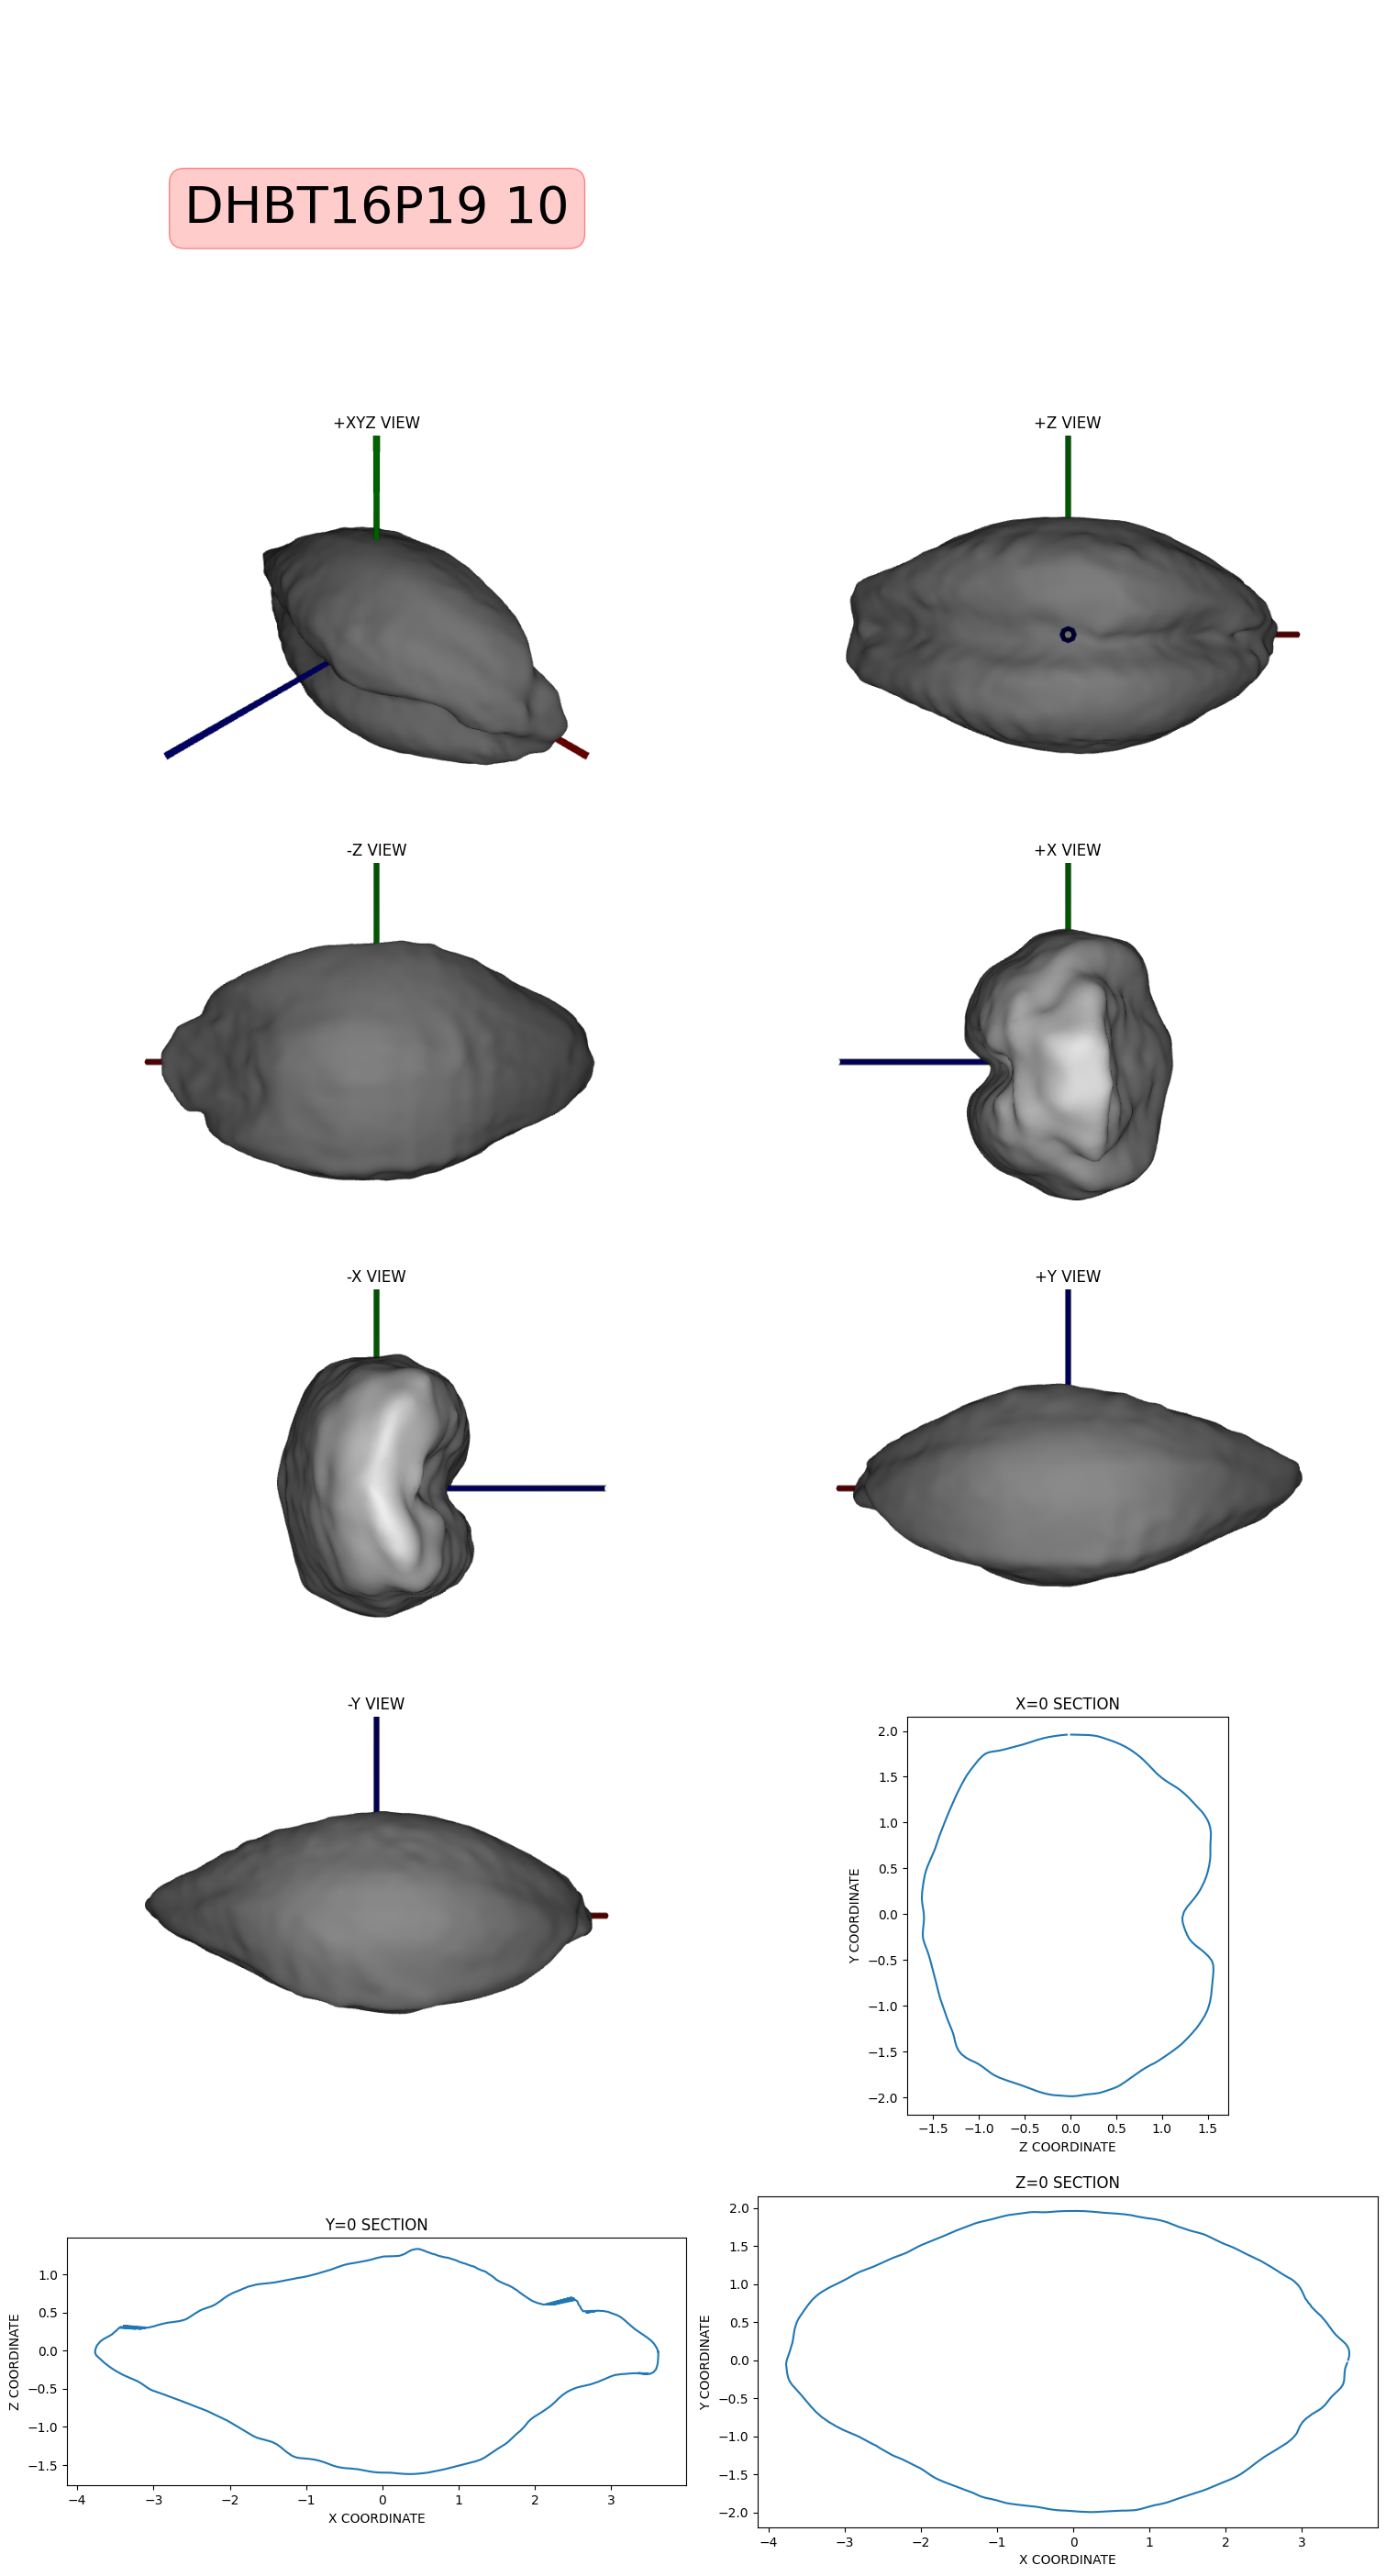

In [10]:
mesh_path1 = "./data/unoriented_dataset_ORIENTED/Dundee/2ROW British/DHBT16P19 10.stl"
grain_sheet(mesh_path1)